In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np
import pickle
import csv
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.externals import joblib
# for scikit-learn <= 0.17 use:
from sklearn.cross_validation import train_test_split
# otherwise:
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib inline

/home/peng/anaconda3/envs/TrafficSign/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/peng/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read the traffic sign name file
label_names = []
with open('./signnames.csv', 'rt') as f:
    reader = csv.reader(f)
    label_names = list(reader)
    
label_name = []
for i in range(43):
    label_name.append(label_names[i+1][1])

In [3]:
EPOCHS = 50
BATCH_SIZE = 128

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 30x30x32. Output = 15x15x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Input = 15x15x32. Output = 13x13x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 13x13x64. Output = 6x6x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Layer 3: Convolutional. Input = 6x6x64. Output = 4x4x128.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(128))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b

    # SOLUTION: Activation.
    conv3 = tf.nn.relu(conv3)

    # SOLUTION: Pooling. Input = 4x4x128. Output = 2x2x128.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 2x2x128. Output = 512.
    fc0   = flatten(conv3)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 512. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(512, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 5: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 6: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [4]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
logits = LeNet(x)
saver = tf.train.Saver()

In [5]:
def normalized(data):
    return data/255.0 - 0.5

In [6]:
init_g = tf.global_variables_initializer()
# judge function accept 1*32*32*3 image in BGR channel!!!
def judge(img):
    img_normalized = normalized(img)
    with tf.Session() as sess:
        sess.run(init_g)
        saver.restore(sess, tf.train.latest_checkpoint('save/'))
        sess = tf.get_default_session()
        result = sess.run(tf.argmax(logits, 1), feed_dict={x: img_normalized})
    return result

In [50]:
# prototype functions for Histogram of Oriented Gradients(HOG):

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the color histograms
    return hist_features


def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() # Remove this line!
    # Return the feature vector
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, block_norm = 'L2-Hys',
                                  visualise=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    # Otherwise call with one output
    else:      
        hog_features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, block_norm = 'L2-Hys',
                       visualise=vis, feature_vector=feature_vec)
        return hog_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=11, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



# prototype functions for Sliding Window Search

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img



def find_signs(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
              cell_per_block, spatial_size, hist_bins, hog_channel):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:   
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 32 was the orginal sampling rate, with 4 cells and 8 pix per cell
    window = 32
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Initialize postive windows
    on_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, on_windows


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    sign_label = []
    sign_position = []
    # Iterate through all detected signs
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if (np.max(nonzerox) - np.min(nonzerox) >= 40 and np.max(nonzeroy) - np.min(nonzeroy) >= 40):
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
            sign_label.append(car_number)
            position = [np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)]
            sign_position.append(position)
    # Return the image
    return img, sign_label, sign_position


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def detector(image):

    windows = []

    search_config = [(190, 280, 1), (200, 300, 1.5), (180, 350, 2), (150, 480, 2.5)]
    # search_config = [(190, 280, 1), (200, 300, 1.5), (150, 480, 2.5)]

    for config in search_config:
        out_img, out_windows = find_signs(image, config[0], config[1], config[2], svc, X_scaler, 
                orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
        windows.append(out_windows)

    windows = [item for sublist in windows for item in sublist]
    
    # Initialize the heatmap
    heat = np.zeros_like(image[:,:,0].astype(np.float))

    # Add heat to each windows in windows list
    heat = add_heat(heat, windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final windows from heatmap using lable function
    labels = label(heatmap)
    num_signs = labels[1]
    draw_img, sign_label, sign_position = draw_labeled_bboxes(np.copy(image), labels)
    
    # judge the types of traffic sign
    sign_types= []
    for i in range(len(sign_label)):
        sign = image[sign_position[i][1]:sign_position[i][3], sign_position[i][0]:sign_position[i][2]]
        sign = sign*255
        sign = cv2.resize(sign, (32, 32))
        sign = cv2.cvtColor(sign, cv2.COLOR_RGB2BGR)
        sign = np.expand_dims(sign, axis=0)
        sign_type = judge(sign)
        sign_types.append(sign_type)
        
        # anotate the traffic sign name in image
        cv2.putText(draw_img, '%s' %label_name[int('%d' %sign_type)], (sign_position[i][0],
                    sign_position[i][1]-10), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0,255,0), 2)
#         cv2.putText(draw_img, '%d: %s' %(sign_type, label_name[sign_type]), (sign_position[i][1]-20,
#                     sign_position[i][0]), cv2.FONT_HERSHEY_COMPLEX, 6, (0,0,255), 25)
    
    return draw_img, sign_types

In [51]:
color_space = 'YCrCb'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16, 16)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

In [52]:
svc = joblib.load("train_model.m")
X_scaler = joblib.load("scaler.save")

INFO:tensorflow:Restoring parameters from save/model.ckpt
INFO:tensorflow:Restoring parameters from save/model.ckpt
INFO:tensorflow:Restoring parameters from save/model.ckpt


[array([40]), array([14]), array([31])]

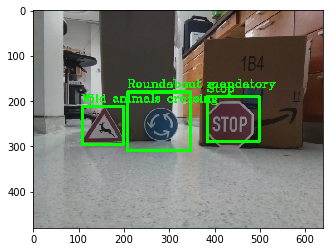

In [53]:
image = mpimg.imread('./test/2.png')
draw_img, sign_types = detector(image)
plt.imshow(draw_img)
sign_types

In [54]:
draw_img *= 255
draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('test/output2.png', draw_img)

True

In [ ]:
windows = []

search_config = [(190, 280, 1), (200, 300, 1.5), (180, 350, 2), (150, 480, 2.5)]

for config in search_config:
    out_img, out_windows = find_signs(image, config[0], config[1], config[2], svc, X_scaler, 
            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel)
    windows.append(out_windows)

windows = [item for sublist in windows for item in sublist]
draw_image = draw_boxes(image, windows)
plt.imshow(draw_image)

In [ ]:
test_out = './test/video_out.mp4'
clip = VideoFileClip('./test/traffic_sign.mp4')
clip_out = clip.fl_image(detector)
%time clip_out.write_videofile(test_out, audio=False)